In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import numpy as np
import datetime
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
register_matplotlib_converters()

from scipy.optimize import curve_fit
from datetime import timedelta
from datetime import datetime
from io import StringIO
from urllib import request as url_request

In [2]:
days_past = -2 # days beyond the start of the data to plot
days_future = 20 # days after the end of the data to predict and plot

myFmt = mdates.DateFormatter('%d/%m') # date formatter for matplotlib
show_every = 2 # int value that defines how often to show a date in the x axis.

coeff_std = 1.1 # coefficient that defines how many standard deviations to use
coeff_std_d = 0.4

In [3]:
def logistic(x, L, k, x0, y0):
    """
    General Logistic function.

    Args:
        x    float or array-like, it represents the time
        L    float, the curve's maximum value
        k    float, the logistic growth rate or steepness of the curve.
        x0   float, the x-value of the sigmoid's midpoint
        y0   float, curve's shift in the y axis
    """
    y = L / (1 + np.exp(-k*(x-x0))) + y0
    return y


In [4]:
def logistic_derivative(x, L, k, x0):
    """
    General Gaussian like function (derivative of the logistic).

    Args:
        x    float or array-like, it represents the time
        L    float, the curve's integral (area under the curve)
        k    float, the logistic growth rate or steepness of the curve.
        x0   float, the x-value of the max value
    """
    y = k * L * (np.exp(-k*(x-x0))) / np.power(1 + np.exp(-k*(x-x0)), 2)
    return y

In [5]:
def fit_curve(curve, ydata, title, ylabel, last_date, coeff_std):
    xdata = np.array(list(range(-len(ydata), 0))) + 1

    if curve.__name__ == 'logistic':
        p0=[20000, 0.5, 1, 0]
        bounds=([0, 0, -100, 0], [200000, 10, 100, 1])
        params_names = ['L', 'k', 'x0', 'y0']
    elif curve.__name__ == 'logistic_derivative':
        p0=[20000, 0.5, 1]
        bounds=([0, 0, -100], [200000, 10, 100])
        params_names = ['L', 'k', 'x0']
    else:
        print('this curve is unknown')
        return -1

    popt, pcov = curve_fit(curve, xdata, ydata, p0=p0, bounds=bounds)

    print(title)
    descr = '    fit: '
    
    for i, param in enumerate(params_names):
        descr = descr + "{}={:.3f}".format(param, popt[i])
        if i < len(params_names) - 1:
            descr = descr + ', '
    print(descr)

    perr = np.sqrt(np.diag(pcov))
    print(perr)

    pworst = popt + coeff_std*perr
    pbest = popt - coeff_std*perr

    fig, ax = plt.subplots(figsize=(15,8))
    
    ax.xaxis.set_major_formatter(myFmt)
    fig.autofmt_xdate()

    total_xaxis = np.array(list(range(-len(ydata) + days_past, days_future))) + 1

    date_xdata = [last_date + timedelta(days=int(i)) for i in xdata]
    date_total_xaxis = [last_date + timedelta(days=int(i)) for i in total_xaxis]

    ax.plot(date_total_xaxis, curve(total_xaxis, *popt), 'g-', label='prediction')
    ax.plot(date_xdata, ydata, 'b-', label='real data')

    future_axis = total_xaxis[len(ydata) - days_past:]
    date_future_axis = [last_date + timedelta(days=int(i)) for i in future_axis]
    ax.fill_between(date_future_axis, curve(future_axis, *pbest), curve(future_axis, *pworst), 
        facecolor='red', alpha=0.2, label='std')

    start = (len(ydata) - days_past - 1) % show_every
    ax.set_xticks(date_total_xaxis[start::show_every])
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    ax.set_title(title + ' - ' + str(last_date.strftime("%d-%m-%Y")))
    ax.legend(loc='upper left')
    ax.grid(True)

    return popt, perr

In [6]:
data = pd.read_csv('../data/final_data/dataCOVID19_es.csv')
Spain = data.groupby('fecha', as_index=False).sum()

In [7]:
Confirmed=Spain.casos.values
Deaths=Spain.muertes.values
dates=pd.to_datetime(Spain.fecha.values)
last_date = datetime.strptime(Spain.fecha.values[-1], "%Y-%m-%d")

In [8]:
nuevos_casos = [np.nan]+list(Spain.casos.values[1:] - Spain.casos.values[:-1])

Number of confirmed cases 47610


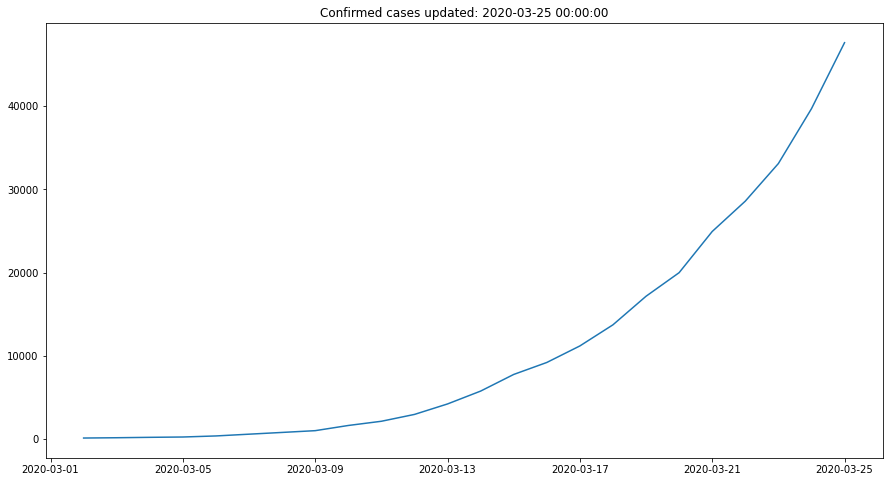

In [9]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(dates,Confirmed)
ax.set_title("Confirmed cases updated: {}".format(dates[-1]));
print('Number of confirmed cases {:.0f}'.format(Confirmed[-1]))

Confirmed
    fit: L=110593.488, k=0.238, x0=1.338, y0=0.000
[2.06436151e+04 1.67689320e-02 1.35551371e+00 3.47046248e+02]


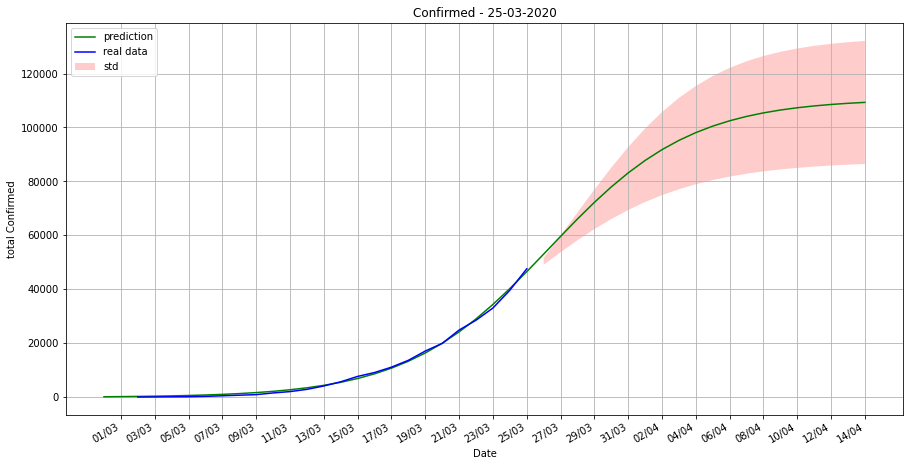

In [10]:
p_cont, err_cont = fit_curve(logistic, Confirmed, 'Confirmed', 'total Confirmed', last_date, coeff_std)

Number of deaths 3434


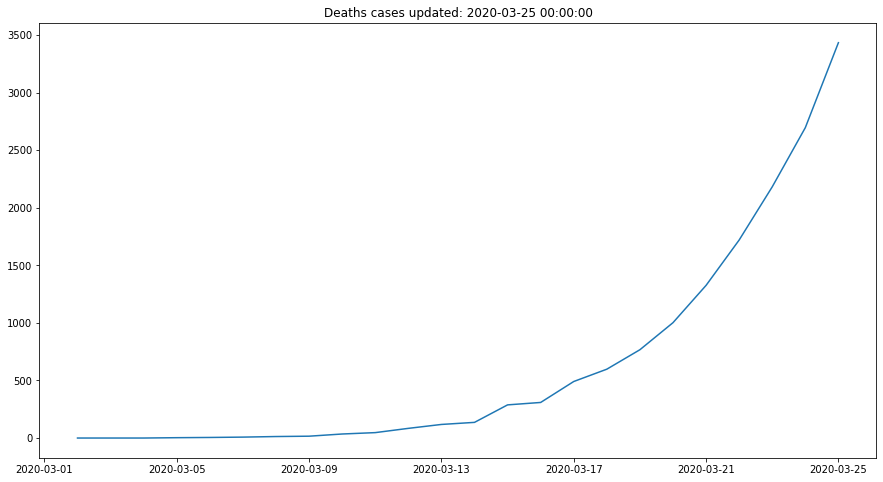

In [11]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(dates,Deaths)
ax.set_title("Deaths cases updated: {}".format(dates[-1]));
print('Number of deaths {:.0f}'.format(Deaths[-1]))

In [12]:
tempVar=np.diff(Confirmed)
tempVar[tempVar==0]=np.nan
newConfirmed=tempVar
datesNewConfirmed=dates[1:]

In [13]:
growth_factor = newConfirmed[1:] / newConfirmed[:-1]
dates_growth_factor = datesNewConfirmed[1:]

print('Last growth factor: {:.3f}'.format(growth_factor[-1]))
print('Mean growth  factor: {:.3f}'.format(np.mean(growth_factor[-5:])))

Last growth factor: 1.205
Mean growth  factor: 1.277


New cases
    fit: L=200000.000, k=0.208, x0=6.063
[1.35656637e+05 3.73432892e-02 5.08242865e+00]


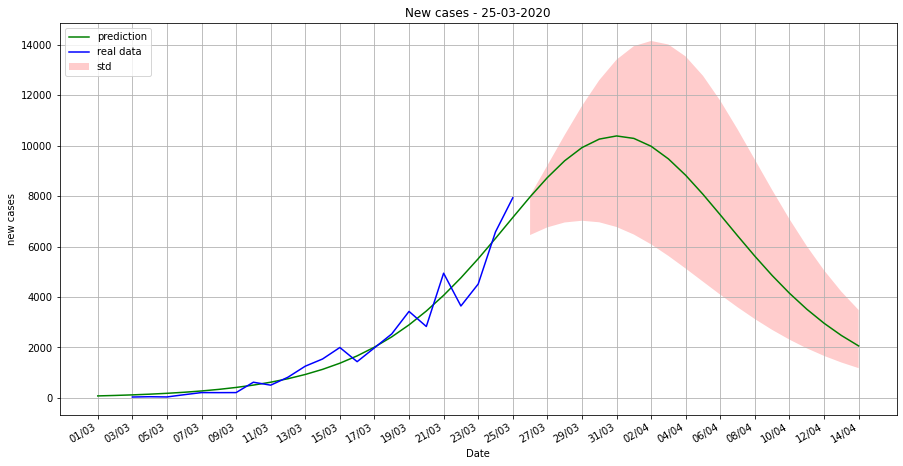

In [14]:
newConfirmed=np.diff(Confirmed)

fit_curve(logistic_derivative, newConfirmed, 'New cases', 'new cases', last_date, coeff_std_d);

New cases
    fit: L=7504.368, k=0.255, x0=2.059
[2.28733220e+03 3.89319055e-02 2.07408835e+00]


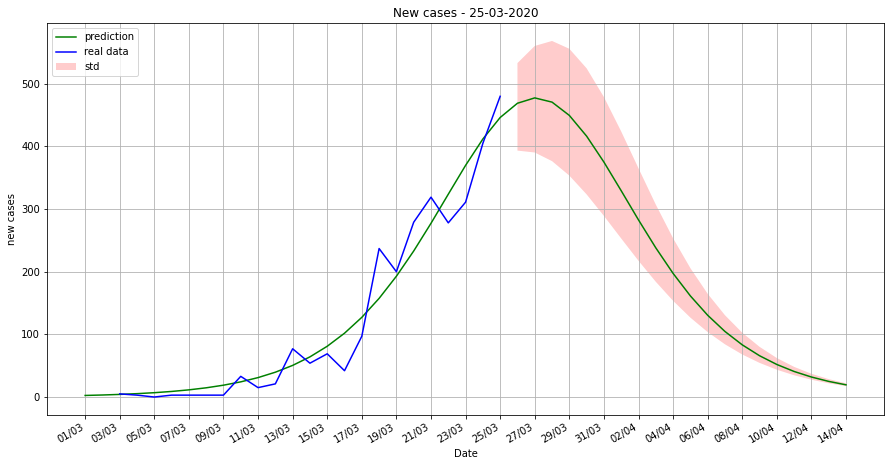

In [15]:
ConfirmedCCAA=data[data.CCAA=='CastillayLeón'].casos.values
fit_curve(logistic_derivative, np.diff(ConfirmedCCAA), 'New cases', 'new cases', last_date, coeff_std_d);